<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Setting" data-toc-modified-id="Setting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting</a></span><ul class="toc-item"><li><span><a href="#Path" data-toc-modified-id="Path-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Path</a></span></li></ul></li><li><span><a href="#時系列データ作成" data-toc-modified-id="時系列データ作成-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>時系列データ作成</a></span><ul class="toc-item"><li><span><a href="#No-Noise" data-toc-modified-id="No-Noise-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>No Noise</a></span></li><li><span><a href="#Noise" data-toc-modified-id="Noise-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Noise</a></span></li></ul></li><li><span><a href="#入力データ作成" data-toc-modified-id="入力データ作成-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>入力データ作成</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Fit" data-toc-modified-id="Fit-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Fit</a></span></li></ul></li><li><span><a href="#Save-Model" data-toc-modified-id="Save-Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Save Model</a></span></li><li><span><a href="#Save-History" data-toc-modified-id="Save-History-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Save History</a></span></li></ul></li><li><span><a href="#history" data-toc-modified-id="history-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>history</a></span></li><li><span><a href="#Predict" data-toc-modified-id="Predict-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict</a></span></li></ul></div>

# create_Conv1d_model__SinCosFunc

1. データ作成
  - 単なるsin関数を含んだ式
  - ノイズを加える
  - 異常波形作成
1. CNN時系列予測
  - [時系列予測を一次元畳み込みを使って解く with Keras - Qiita
      ](https://qiita.com/niisan-tokyo/items/a94dbd3134219f19cab1)
  - その背景を $windowsize$ 5-60程度で予測するConv1d層の作成

In [103]:
ipynb_title = "create_Conv1d_model__SimpleSinFunc"

In [104]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

import keras
print("Keras version : ", keras.__version__)

Keras version :  2.1.3


## Setting

### Path

In [105]:
HOME = Path(os.getcwd()).parent
print(HOME)

/Users/sugisaki/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku


In [106]:
path_list = []
keras_model_h5_Path = HOME / "keras_model_h5_Path"
path_list.append(keras_model_h5_Path)
data_Path = HOME / "data"
path_list.append(data_Path)
plot_images_Path = data_Path / "plot_images"
path_list.append(plot_images_Path)
fit_hitory_Path = HOME / "fit_history"
path_list.append(fit_hitory_Path)

for _Path in path_list:
    _path = str(keras_model_h5_Path)
    if not os.path.exists(_path):
        os.makedirs(name=_path)
        print("make a directory: \n\t", _path)
    else:
        print(os.path.exists(_path), ": ", _path)

True :  /Users/sugisaki/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path
True :  /Users/sugisaki/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path
True :  /Users/sugisaki/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path
True :  /Users/sugisaki/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path


## 時系列データ作成

$$
\textbf{toyfunc(t)} = \sin\left( \frac{2 \pi}{T} t \right) + 0.05 \cdot \varepsilon
$$
$$
\varepsilon \text{は平均}0 \text{,分散}1 \text{の正規分布に従うノイズ}
$$ 

- <a href="https://ja.wikipedia.org/wiki/%E3%83%9B%E3%83%AF%E3%82%A4%E3%83%88%E3%83%8E%E3%82%A4%E3%82%BA">ホワイトノイズ - Wikipedia</a>
- <a href="https://ja.wikipedia.org/wiki/%E4%B9%B1%E6%95%B0%E5%88%97#%E6%AD%A3%E8%A6%8F%E4%B9%B1%E6%95%B0">乱数列 - Wikipedia</a>

In [107]:
def mySin(t, period=100):
    """
    時刻t, 周期period
    """
    return np.sin(2.0 * np.pi * t/period)

### No Noise

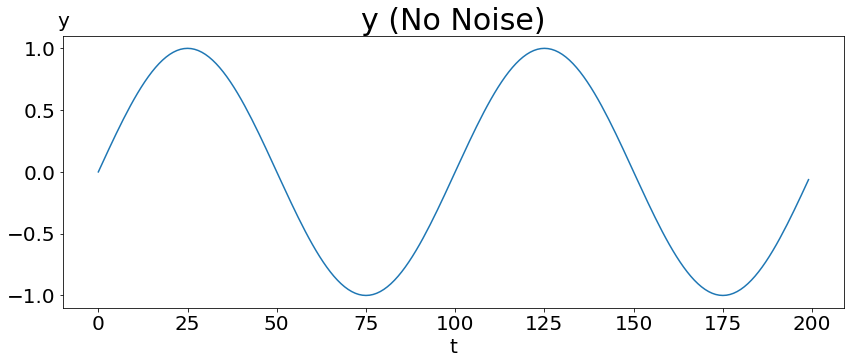

In [108]:
# No Noise
t = np.arange(start=0, stop=200, step=1)
y = mySin(t=t, period=100)

#----------
# Plot
#----------
fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)

ax.plot(t, y)

title = "y (No Noise)"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0., y=1.02)
ax.tick_params(labelsize=20)

plt.show()

### Noise


In [109]:
# Add Noise
def toy_func(tStart=0, tStop=100, tStep=1, noiseAmpl=0.05):
    """
    T : sin波の周期
    noiseAmpl : ノイズの係数(振幅)
      """
    t = np.arange(start=tStart, stop=tStop, step=tStep)
    noise = np.random.randn(t.shape[0])  # mean=0, standard_deviation=1
    return (t,
            mySin(t, period=100)
            + noiseAmpl * noise )

$$
\textbf{toyfunc(t)} = \sin\left( \frac{2 \pi}{T} t \right) + 0.05 \cdot \varepsilon
$$
$$
\varepsilon \text{は平均}0 \text{,分散}1 \text{の正規分布に従うノイズ}
$$ 

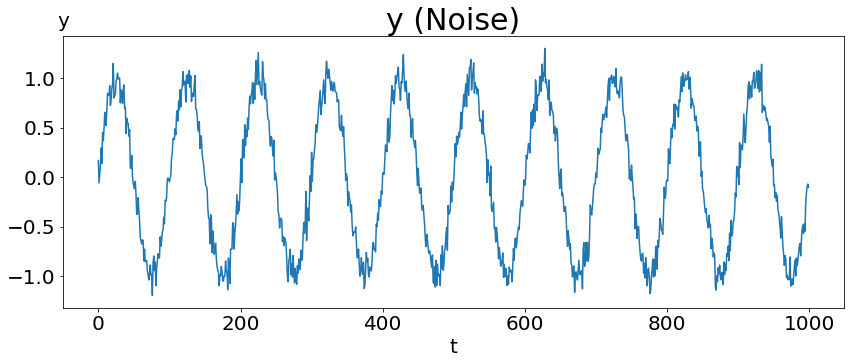

In [110]:
filename = ipynb_title + "__wave_with_noise.png"

fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)
t, y = toy_func(tStop=1000, noiseAmpl=0.1)
ax.plot(t, y)

title = "y (Noise)"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0.0, y=1.02)
ax.tick_params(labelsize=20)

fig.savefig(fname=str(plot_images_Path / filename))
plt.show()

## 入力データ作成

<img src="images/create_input_data.gif" style="width: 70%; height: 70%">

In [111]:
#----------------------------------------
# Parameters
#----------------------------------------
windowsize = 60
predictsize = 1
sample_data_size = 10000
wave_size = sample_data_size
trainsize = 10000

#----------------------------------------
# Sample Wave
#----------------------------------------
t, sample_wave = toy_func(tStop=sample_data_size, noiseAmpl=0.05)
print(sample_wave.shape)

(10000,)


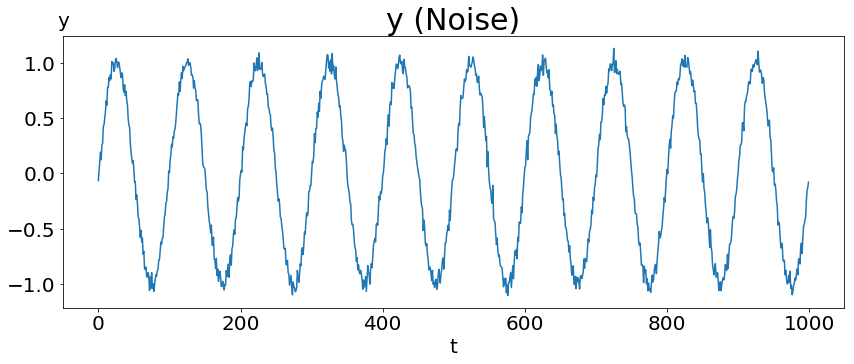

In [112]:
#----------------------------------------
# plot sample wave
#----------------------------------------
filename = ipynb_title + "__wave_with_noise.png"

fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)
ax.plot(t[:1000], sample_wave[:1000])

title = "y (Noise)"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0.0, y=1.02)
ax.tick_params(labelsize=20)

fig.savefig(fname=str(plot_images_Path / filename))
plt.show()

In [113]:
#----------------------------------------
# create input data
#----------------------------------------
input_data  = np.empty(shape=(0, windowsize))
output_data = np.empty(shape=(0, predictsize))
print(input_data.shape)
print(output_data.shape)
for i in range( sample_wave.shape[0] - (windowsize + predictsize) + 1 ):
    input_data = np.append(arr   =input_data,
                           values=sample_wave[i:(i+windowsize)].reshape(1, -1),
                           axis  =0)
    output_data = np.append(arr   =output_data,
                            values=sample_wave[(i+windowsize):(i+windowsize+predictsize)].reshape(1, -1),
                            axis  =0)
print("input_data.shape  : ", input_data.shape)
print("output_data.shape : ", output_data.shape)
#--------------------
# Kerasのモデルに入力できる形にするためにreshapeして次元を足す
#--------------------
input_data = input_data.reshape((-1, windowsize, 1))
output_data = output_data.reshape((-1, predictsize, 1))
print("input_data.shape  : ", input_data.shape)
print("output_data.shape : ", output_data.shape)

(0, 60)
(0, 1)
input_data.shape  :  (9940, 60)
output_data.shape :  (9940, 1)
input_data.shape  :  (9940, 60, 1)
output_data.shape :  (9940, 1, 1)


In [114]:
train_x, test_x = input_data[:trainsize], input_data[trainsize:]
train_y, test_y = output_data[:trainsize], output_data[trainsize:]
print("train_x.shape : ", train_x.shape)
print("train_y.shape : ", train_y.shape)
print("test_x.shape  : ", test_x.shape)
print("test_y.shape  : ", test_y.shape)

train_x.shape :  (9940, 60, 1)
train_y.shape :  (9940, 1, 1)
test_x.shape  :  (0, 60, 1)
test_y.shape  :  (0, 1, 1)


## Model

- Conv1d
  - https://keras.io/ja/layers/convolutional/#conv1d
- 正則化
  - https://keras.io/ja/regularizers/
  

In [115]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.convolutional import Conv1D, UpSampling1D
from keras.layers.pooling import MaxPooling1D
from keras import regularizers

In [116]:
model = Sequential()
model.add( Conv1D(filters=windowsize, kernel_size=10, strides=1, padding="same",
                  activation="relu",
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  input_shape=(windowsize, 1),
                  ) )
model.add( MaxPooling1D(pool_size=2, padding="same") )
model.add( Conv1D(filters=windowsize, kernel_size=10, padding='same', activation='relu',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.0),
                  ) )
model.add( MaxPooling1D(pool_size=5, padding='same') )
model.add( Conv1D(filters=int(windowsize/2), kernel_size=10, padding='same', activation='relu',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  ) )
model.add( MaxPooling1D(pool_size=6, padding='same') )
model.add( Conv1D(filters=int(windowsize/2/2), kernel_size=10, padding='same', activation='relu',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  ) )
model.add( Conv1D(filters=1, kernel_size=8, padding='same', activation='tanh',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  ) )

model.compile(loss='mse', optimizer='adam')

In [117]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 60, 60)            660       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 30, 60)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 30, 60)            36060     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 6, 60)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 6, 30)             18030     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1, 30)             0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1, 15)             4515      
__________

#### Fit

In [118]:
epochs = 100
history = model.fit(x=train_x,
                    y=train_y,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8946 samples, validate on 994 samples
Epoch 1/100
8946/8946 [==============================] - 5s 551us/step - loss: 0.0274 - val_loss: 0.0033
Epoch 2/100
8946/8946 [==============================] - 4s 460us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 3/100
8946/8946 [==============================] - 4s 464us/step - loss: 0.0032 - val_loss: 0.0040
Epoch 4/100
8946/8946 [==============================] - 4s 464us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 5/100
8946/8946 [==============================] - 4s 468us/step - loss: 0.0031 - val_loss: 0.0035
Epoch 6/100
8946/8946 [==============================] - 4s 492us/step - loss: 0.0031 - val_loss: 0.0027
Epoch 7/100
8946/8946 [==============================] - 4s 477us/step - loss: 0.0031 - val_loss: 0.0040
Epoch 8/100
8946/8946 [==============================] - 4s 486us/step - loss: 0.0032 - val_loss: 0.0044
Epoch 9/100
8946/8946 [==============================] - 4s 474us/step - loss: 0.0031 - val_loss: 0.0041
Epoch 10

Epoch 78/100
8946/8946 [==============================] - 4s 474us/step - loss: 0.0024 - val_loss: 0.0027
Epoch 79/100
8946/8946 [==============================] - 4s 476us/step - loss: 0.0024 - val_loss: 0.0028
Epoch 80/100
8946/8946 [==============================] - 4s 467us/step - loss: 0.0024 - val_loss: 0.0028
Epoch 81/100
8946/8946 [==============================] - 4s 473us/step - loss: 0.0024 - val_loss: 0.0029
Epoch 82/100
8946/8946 [==============================] - 4s 483us/step - loss: 0.0023 - val_loss: 0.0032
Epoch 83/100
8946/8946 [==============================] - 4s 475us/step - loss: 0.0023 - val_loss: 0.0028
Epoch 84/100
8946/8946 [==============================] - 4s 468us/step - loss: 0.0023 - val_loss: 0.0028
Epoch 85/100
8946/8946 [==============================] - 4s 470us/step - loss: 0.0023 - val_loss: 0.0028
Epoch 86/100
8946/8946 [==============================] - 4s 483us/step - loss: 0.0023 - val_loss: 0.0029
Epoch 87/100
8946/8946 [======================

### Save Model

In [119]:
modelpath = str(keras_model_h5_Path / ("model__" + ipynb_title + ".h5"))
#if not os.path.exists(modelpath):
model.save(filepath=modelpath, overwrite=False)

[WARNING] /Users/sugisaki/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path/model__create_Conv1d_model__SimpleSinFunc.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


In [125]:
from keras.models import load_model

In [126]:
epochs = 100
modelpath = str(keras_model_h5_Path / ("model__" + ipynb_title + ".h5"))
model = load_model(filepath=modelpath)

### Save History

In [127]:
#import pickle
#
#history_path = str(fit_hitory_Path / ("fit_history__{}.history.pickle".format(ipynb_title)))
#with open(history_path, "wb") as f:
#    pickle.dump(obj=history, file=f)

## history

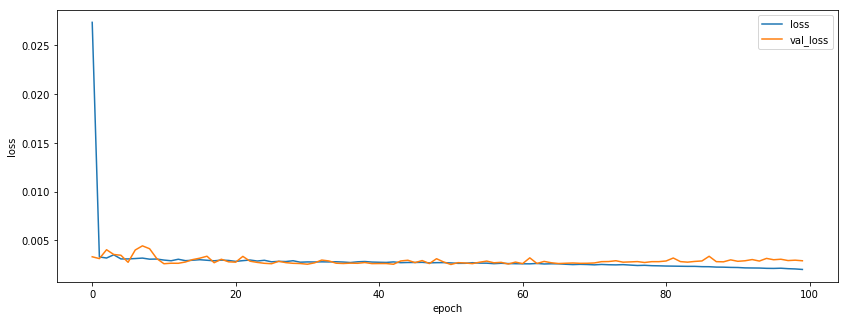

In [128]:
filename = ipynb_title + "__epochs_loss.png"

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1,1,1)

ax.plot(range(epochs), history.history['loss'],     label='loss')
ax.plot(range(epochs), history.history['val_loss'], label='val_loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend() 

fig.savefig(fname=str(plot_images_Path / filename))
plt.show()

## Predict

-0.5178291
(9940, 1, 1)
(9940,)


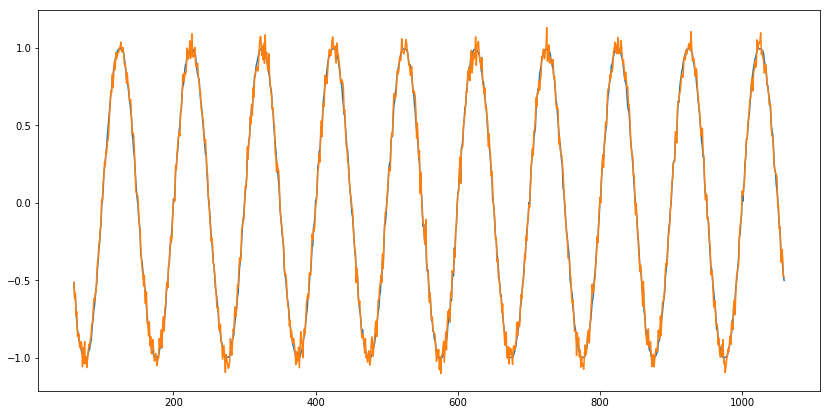

In [129]:
pred = model.predict(train_x)
print(pred.squeeze()[0])
print(pred.shape)
print(pred.squeeze().shape)

time = 1000

fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(windowsize, wave_size)[:time], pred.squeeze()[:time])
ax.plot(np.arange(windowsize, wave_size)[:time], train_y.squeeze()[:time])
#ax.plot(np.arange(windowsize, wave_size)[:500], sample_wave[windowsize:][:500])
plt.show()

# End